# Compare offline turbulence to observations
### function of wind shear and temperature gradient

In [17]:
# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc


# -------------------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context('paper')

# -------------------------------------------------------------------------------------------------------
# Directories
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dirDataSCP = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'
dirDataSNQ = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'

### Surface observations

In [13]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dirDataSNQ)
SNQ = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

# Indices of simulated turbulence times (observations exist, wind > 2m/s, snow is present)
SNQind = np.nonzero((SNQ.SP == 1).values &
                    (SNQ.WIND > 2).values &
                    (~(np.isnan(SNQ.SensFlux)).values |
                    ~(np.isnan(SNQ.LatFlux)).values))

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dirDataSCP)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
SCP['w_tc__1m'] = fluxObs.w_tc__1m
SCP['w_tc_10m'] = fluxObs.w_tc__10m_M

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
Tsfc = (radObs.Rlw_out / sigma) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind speed magnitude
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_15m > 10] = np.nan
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_2m > 10] = np.nan

# Bulk Richardson number
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

# Indices of stable periods (simulated)
SCPind = np.nonzero((SCP.RiBulk_15m > 0.).values)

## Offline Turbulence results

#### SCP
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations

#### SNQ
- Simulation run in TF.OfflineTurb.SNQ
- the resulting netcdf was copied from the SNQ data directory to the project level directory. Re-running the script won't change the results in this script unless explicitly moved again.
- Simulations only run for periods of wind > 2m/s

In [8]:
os.chdir(dirProj)
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')

# -------------------------------------------------------------------------------------------------------
# SNQ Offline Turbulence results
SNQ_sensible = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
SNQ_latent = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

# -------------------------------------------------------------------------------------------------------
# SCP Offline Turbulence results
SCP_sensible_1m = xr.open_dataset('OfflineTurb.SCP.sensible_1m.ALL.nc')
SCP_sensible_15m = xr.open_dataset('OfflineTurb.SCP.sensible_15m.ALL.nc')
SCP_latent_1m = xr.open_dataset('OfflineTurb.SCP.latent_1m.ALL.nc')
SCP_latent_15m = xr.open_dataset('OfflineTurb.SCP.latent_15m.ALL.nc')

### Temperature Gradient

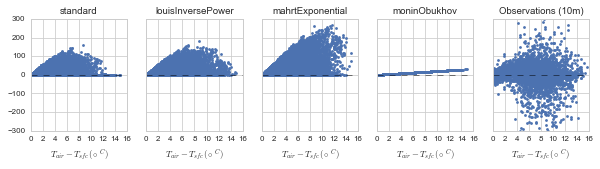

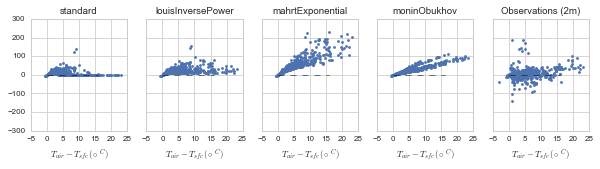

In [26]:
# -------------------------------------------------------------------------------------------------------
# SCP
fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()
# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind], 
            SCP_sensible_15m[stab].values, '.')
    ax.plot([0, 16], [0, 0], 'k--', linewidth=.5)
    ax.set_title(stab)
    ax.set_ylim(-300, 300)
    ax.set_xlim(0, 16)
    ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')

# Observed turbulence
ax = axes[-1]
ax.plot(SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind], -SCP.w_tc_10m[SCPind], '.')
ax.plot([0, 16], [0, 0], 'k--', linewidth=.5)
ax.set_title('Observations (10m)')
ax.set_ylim(-300, 300)
ax.set_xlim(0, 16)
ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')

# -------------------------------------------------------------------------------------------------------
# SNQ
fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()
# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], 
            SNQ_sensible[stab].values, '.')
    ax.plot([0, 16], [0, 0], 'k--', linewidth=.5)
    ax.set_title(stab)
    ax.set_ylim(-300, 300)
    ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')
# Observed turbulence
ax = axes[-1]
ax.plot(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], SNQ.SensFlux[SNQind], '.')
ax.plot([0, 16], [0, 0], 'k--', linewidth=.5)
ax.set_title('Observations (2m)')
ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')


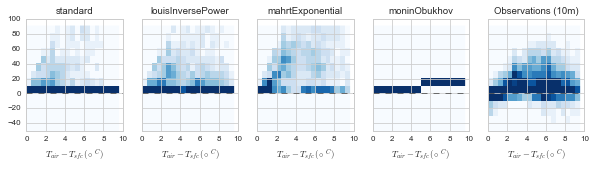

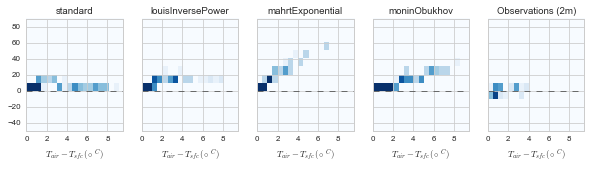

In [87]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -50
ymax = 100
xmin = 0
xmax = 10
dy = 10
dx = .5

# Format figure
cmap = kgraph.cmap_discretize(cm.Blues, 15)
fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.hist2d(SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind], SCP_sensible_15m[stab].values,
              bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
              cmap=cmap, vmin=5, vmax=100)
    ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
    ax.set_title(stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')

# Observed turbulence
ax = axes[-1]
ax.hist2d(SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind], -SCP.w_tc_10m[SCPind],
          bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
          cmap=cmap, vmin=5, vmax=100)
ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
ax.set_title('Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')

# -------------------------------------------------------------------------------------------------------
# SNQ
ymin = -50
ymax = 100
dy = 10
xmin = 0
xmax = 10
dx = .5

fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()
# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.hist2d(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], SNQ_sensible[stab].values,
              bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
              cmap=cmap, vmin=5, vmax=20)
    ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
    ax.set_title(stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')
# Observed turbulence
ax = axes[-1]
ax.hist2d(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], SNQ.SensFlux[SNQind],
          bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
          cmap=cmap, vmin=5, vmax=20)
ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
ax.set_title('Observations (2m)')
ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')


#### Wind

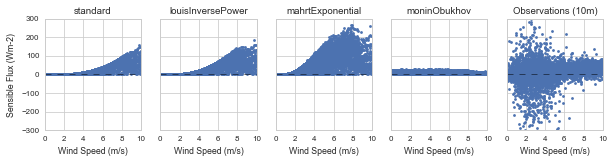

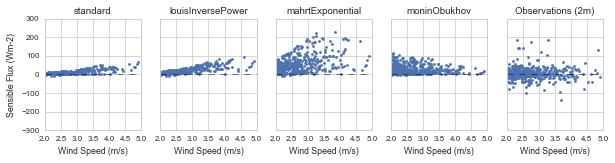

In [34]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -300
ymax = 300
xmin = 0
xmax = 10

fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()
# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(SCP.UBar_15m[SCPind], 
            SCP_sensible_15m[stab].values, '.')
    ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
    ax.set_title(stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Wind Speed (m/s)')

# Observed turbulence
ax = axes[-1]
ax.plot(SCP.UBar_15m[SCPind], -SCP.w_tc_10m[SCPind], '.')
ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
ax.set_title('Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Wind Speed (m/s)')
axes[0].set_ylabel('Sensible Flux (Wm-2)')

# -------------------------------------------------------------------------------------------------------
# SNQ
ymin = -300
ymax = 300
xmin = 2
xmax = 5

fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()
# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(SNQ.WIND[SNQind], 
            SNQ_sensible[stab].values, '.')
    ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
    ax.set_title(stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Wind Speed (m/s)')
# Observed turbulence
ax = axes[-1]
ax.plot(SNQ.WIND[SNQind], SNQ.SensFlux[SNQind], '.')
ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
ax.set_title('Observations (2m)')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_xlim(xmin, xmax)
axes[0].set_ylabel('Sensible Flux (Wm-2)')


#### Notes:
- No obvious functional relationship between observed turbulence and wind
- Assumed form of relationship between simulated turbulence and wind in the bulk aerodynamic formulas does not appear in the observations
- SNQ has the same pattern between simulations and observations

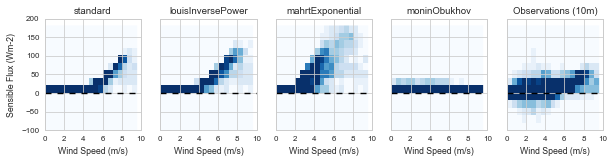

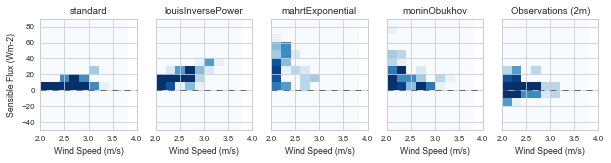

In [85]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -100
ymax = 200
xmin = 0
xmax = 10

# Figure formatting
fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()
cmap = kgraph.cmap_discretize(cm.Blues, 15)

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.hist2d(filled[SCPind].values, SCP_sensible_15m[stab].values,
              bins=(np.arange(xmin, xmax, .5), np.arange(ymin, ymax, 20)),
              cmap=cmap, vmin=5, vmax=100)
    ax.plot([xmin, xmax], [0, 0], 'k--')
    ax.set_title(stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Wind Speed (m/s)')

# Observed turbulence
ax = axes[-1]
ax.hist2d(SCP.UBar_15m[SCPind], -SCP.w_tc_10m[SCPind],
          bins=(np.arange(xmin, xmax, .5), np.arange(ymin, ymax, 20)),
          cmap=cmap, vmin=5, vmax=100)
ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_title('Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Wind Speed (m/s)')
axes[0].set_ylabel('Sensible Flux (Wm-2)')

# -------------------------------------------------------------------------------------------------------
# SNQ
ymin = -50
ymax = 100
dy = 10
xmin = 2
xmax = 4
dx = .2

fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharex='col', sharey='row')
axes = axes.flatten()
# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.hist2d(SNQ.WIND[SNQind], SNQ_sensible[stab].values,
              bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
              cmap=cmap, vmin=5, vmax=20)
    ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
    ax.set_title(stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Wind Speed (m/s)')
# Observed turbulence
ax = axes[-1]
ax.hist2d(SNQ.WIND[SNQind], SNQ.SensFlux[SNQind].values,
          bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
          cmap=cmap, vmin=5, vmax=20)
ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
ax.set_title('Observations (2m)')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_xlim(xmin, xmax)
axes[0].set_ylabel('Sensible Flux (Wm-2)')
